# Image Offsets: Process sequence

This notebook transforms the procedures developed in `Offsets_1.ipynb` into callable functions. 

These functions are used in a loop to process an entire sequence of images. Results are later examined in plots. 

The end product is a series of FITS tables, one per input image, that contain the star offsets in relation to the reference image. These tables should be used in a subsequent notebook to generate the actual arrays with pixel offsets that are used by drizzle to figure out the pixel mapping.

Originally this notebook was developed with the ISO 12800 data set as the test data. In the current version, it is configured to use a different data set. Statements specific to the original data set were comented out.

In [1]:
# %matplotlib widget

import time

import os, glob

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from astropy.stats import SigmaClip
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans

from photutils import centroids
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from photutils.background import Background2D, MedianBackground, ModeEstimatorBackground

import rawpy
import exifread

from datapath import DATA

## Initialization

Define values to be used in the processing functions, and throughout the script.

In [2]:
# ISO 12800 data set

# # images to be drizzled 
# data_dirpath = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/')
# image_list = list(glob.glob(data_dirpath + '/*.ARW'))
# image_list.sort()

# # reference image - this will be the image which subsequent images will have their 
# # offsets computed against.
# ref_dirpath = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/')
# reference_fname = os.path.join(ref_dirpath, 'DSC03770.ARW')

# # since the reference image was included in the image list by the glob command, it
# # has to be removed here
# image_list = image_list[1:]

In [3]:
# ISO 6400 data set

# # images to be drizzled 
# data_dirpath = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/6400/light/')
# image_list = list(glob.glob(data_dirpath + '/*.ARW'))
# image_list.sort()

# # reference image - this will be the image which subsequent images will have their 
# # offsets computed against. We want here that this be the same reference used for the
# # 12800 data set, so both data sets can be drizzled onto a common pixel grid.
# ref_dirpath = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/')
# reference_fname = os.path.join(ref_dirpath, 'DSC03770.ARW')

# # we need to process images in a given order: from the closest (in time) to the reference
# # image, to the most distant.
# image_list.reverse()

# image_list

In [4]:
# Andromeda data set

# images to be drizzled 
data_dirpath = os.path.join(DATA,'astrophotography_data/Andromeda_2022/135mm1s3200ISO')
image_list = list(glob.glob(data_dirpath + '/*.cutout.fits'))
image_list.sort()

# reference image - this will be the image which subsequent images will have their 
# offsets computed against. We want here that this be the same reference used for the
# 12800 data set, so both data sets can be drizzled onto a common pixel grid.
ref_dirpath = os.path.join(DATA,'astrophotography_data/Andromeda_2022/135mm1s3200ISO')
reference_fname_arw = os.path.join(ref_dirpath, 'DSC00362.ARW')
reference_fname = os.path.join(ref_dirpath, 'DSC00362.cutout.fits')

# since the reference image was included in the image list by the glob command, it
# has to be removed here
image_list = image_list[1:]

print(len(image_list))
image_list

899


['/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00363.cutout.fits',
 '/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00364.cutout.fits',
 '/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00365.cutout.fits',
 '/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00366.cutout.fits',
 '/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00367.cutout.fits',
 '/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00368.cutout.fits',
 '/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00369.cutout.fits',
 '/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00370.cutout.fits',
 '/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00371.cutout.fits',
 '/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00372.cutout.fits',
 '/Users/b

In [5]:
# normalization factors to get the roundest star images (as per Offsets_1 notebook)
red_norm = 1.6  
blue_norm = 1.39

# parameters to control background subtraction
bkg_cell_footprint = (100, 100)
bkg_filter = (11, 11)

bkg_sigma_clip = SigmaClip(sigma=5.)
bkg_kernel = Gaussian2DKernel(x_stddev=1)
bkg_estimator = ModeEstimatorBackground()

# parameters for star finding
# dao_fwhm = 5.   # ISO 12800
# dao_fwhm = 6.0    # ISO 6400
dao_fwhm = 7.0    # Andromeda
# dao_threshold = 2000.   # ISO 12800
# dao_threshold = 1200.   # ISO 6400
# dao_threshold = 600.   # Andromeda 6400
dao_threshold = 200.   # Andromeda 3200, 1600
sharplo = 0.1
sharphi = 1.0
roundlo = -0.9 
roundhi = 0.9

# proximity = 3.5   # ISO 12800
# proximity = 4.   # ISO 6400
proximity = 10.   # Andromeda

# tolerance to detect condition that search is stuck
tol = 0.5

In [6]:
# read reference image - we need to read it here to get the camera color array specification.
raw = rawpy.imread(reference_fname_arw)
ref_imarray = raw.raw_image_visible.astype(float)

In [7]:
# masks that isolate the RGB pixels - these are camera-dependent and work with all images
colors_array = raw.raw_colors_visible

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

Using normalizations derived from passband spectral response is *much* better than using normalizations derived from minimization of sky background variance (contrary to the initial finding in notebook Offsets_1). The likely cause is that the spectral-based normalization creates more well-behaved star images. The high variance in sky background doesn't seem to get in the way of detecting stars.

The best run with smooth background on the ISO 12800 data generated 240 detections with a complete data set. The same run but with spectral-based color band normalizations resulted in 550 detections.

## Processing functions

In [8]:
# computes position offsets between two tables. 
def get_offsets(sources, sources_prev):

    sources.add_column(np.nan, name='xoffset')
    sources.add_column(np.nan, name='yoffset')
    sources.add_column(0.0, name='xoffset_prev')
    sources.add_column(0.0, name='yoffset_prev')
    sources.add_column(0, name='ref_row')
    sources.add_column(0, name='prev_row')

    # loop over rows in previous table
    for row_index_prev in range(len(sources_prev)):
        # index in reference table
        ref_row = sources_prev[row_index_prev]['ref_row']

        # if previous table does not contain a pointer to 
        # the reference table, ignore.
        if ref_row == 0:
            continue

        # get position in previous table
        x_prev = sources_prev[row_index_prev]['xcentroid']
        y_prev = sources_prev[row_index_prev]['ycentroid']

        # loop over rows in current table
        for row_index in range(len(sources)):
            x = sources[row_index]['xcentroid']
            y = sources[row_index]['ycentroid']

            # offsets in relation to previous table - these are the ones to check for proximity
            x_off_previous = x - x_prev
            y_off_previous = y - y_prev

            # check for proximity, and store relevant info if found
            if abs(x_off_previous) <= proximity and abs(y_off_previous) <= proximity:

                # offsets in relation to reference table
                sources[row_index]['xoffset'] = x - sources_ref[ref_row]['xcentroid']
                sources[row_index]['yoffset'] = y - sources_ref[ref_row]['ycentroid']

                # offsets in relation to previous table
                sources[row_index]['xoffset_prev'] = x_off_previous
                sources[row_index]['yoffset_prev'] = y_off_previous

                # store pointers to rows in reference and previous tables
                sources[row_index]['ref_row'] = ref_row
                sources[row_index]['prev_row'] = row_index_prev
                
                #TODO 
                # instead of breaking, do an estimate of where the centroid would be,
                # given the current position, and the offsets from the previous table.
                # In other words, repeat the offset from the previous table. See if this
                # will cause the finding algorithm to pick up in the next image.

                break # if there is another star that matches the criterion, just ignore it
                
    return sources

In [9]:
def subtract_background(imarray, red_norm=1.0, blue_norm=1.0):

    # red_norm and blue_norm are normalization parameters applied to the R and B bands (assume
    # G=1) in order to make the star images as well-behaved as possible, in terms of being 
    # well represented, on average, by the daofind Gaussian. Ideally a different normalization 
    # should be applied to each star, depending on its color index, but this will be left as
    # a possible (but not very likely) future improvement. For now, we assume that an average,
    # frame-wide single normalization should suffice (statistically).
    
    # separate color bands
    red_array = imarray * red_mask
    green_array = imarray * green_mask
    blue_array = imarray * blue_mask
    
    # interpolate over the masked pixels in each band, so the background estimator 
    # is presented with a smooth array entirely filled with valid data
    red_array[red_array == 0.0] = np.nan
    green_array[green_array == 0.0] = np.nan
    blue_array[blue_array == 0.0] = np.nan

    red_array = interpolate_replace_nans(red_array, bkg_kernel)
    green_array = interpolate_replace_nans(green_array, bkg_kernel)
    blue_array = interpolate_replace_nans(blue_array, bkg_kernel)

    red_array[np.isnan(red_array)] = 0.
    green_array[np.isnan(green_array)] = 0.
    blue_array[np.isnan(blue_array)] = 0.
    
    # fit background model to each smoothed-out color band
    red_bkg = Background2D(red_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
    green_bkg = Background2D(green_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
    blue_bkg = Background2D(blue_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)

    # subtract background from each masked color array
    subtracted = imarray - red_bkg.background * red_mask - \
                           green_bkg.background * green_mask - \
                           blue_bkg.background * blue_mask

    # after background subtraction, apply color band normalization. This has to be done separately
    # from step above for the background on each band to remain zero on average.
    subtracted = (subtracted * red_mask * red_norm) + \
                 (subtracted * green_mask) + \
                 (subtracted * blue_mask * blue_norm)

    return subtracted

In [10]:
class CentroidFinder():
    def __init__(self, x_estimate, y_estimate, size, sky, threshold):
        self.x_estimate = x_estimate
        self.y_estimate = y_estimate
        self.sky = sky
        self.threshold = threshold
        self.size = int(size)
        
        self.result = Table()
        
    def find(self, image):
#         try:
        x, y = centroids.centroid_sources(image, self.x_estimate, self.y_estimate, 
                                          box_size=self.size, centroid_func=centroids.centroid_com) 
        self.result['xcentroid'] = x
        self.result['ycentroid'] = y
#         except ValueError as e:
#             raise ValueError(str(e))

        return self.result                

In [11]:
# creates a table with star positions, given a path to an image file
def find_stars(path, sources_prev=None):


    f = fits.open(path)
    imarray = f[1].data
    f.close()    
    
    
# TODO background was already subtracted.
#         subtracted = subtract_background(imarray, red_norm=red_norm, blue_norm=blue_norm)
    subtracted = imarray

    global_median = np.median(subtracted)

    # find stars
    if sources_prev is None:
        daofind = DAOStarFinder(fwhm=dao_fwhm, sky=global_median, threshold=dao_threshold,
                                sharplo=sharplo, sharphi=sharphi,
                                roundlo=roundlo, roundhi=roundhi) 
        sources = daofind(subtracted)
    else:
        # offsets are added in reverse, to generate an estimate further away from the current position.
        x_estimate = sources_prev['xcentroid'] - sources_prev['xoffset_prev'] 
        y_estimate = sources_prev['ycentroid'] - sources_prev['yoffset_prev'] 

#             positions = [(x,y) for x,y in zip(x_estimate, y_estimate)]
#             daofind = DAOStarFinder(xycoords=np.array(positions), fwhm=dao_fwhm, 
#                                     sky=global_median,
#                                     threshold=dao_threshold,
#                                     sharplo=sharplo, sharphi=sharphi,
#                                     roundlo=roundlo, roundhi=roundhi) 
#             sources = daofind(subtracted)

        try:
            finder = CentroidFinder(x_estimate, y_estimate, dao_fwhm*2+1, global_median, dao_threshold)
            sources = finder.find(subtracted)  # 1
        except ValueError:
            print("Found points outside image. Discard them.")
            row = 0
            for xe, ye in zip(x_estimate, y_estimate):
                if xe < 10 or xe >= imarray.shape[1]-10 or ye < 10 or ye >= imarray.shape[0]-10:
                    print(xe, ye, imarray.shape[1], imarray.shape[0])
                    x_estimate[row] = np.NaN
                    y_estimate[row] = np.NaN
                    print(xe, ye, imarray.shape[1], imarray.shape[0])
                row += 1

            sources_reject = Table({'xcentroid': x_estimate, 'ycentroid': y_estimate})

            print("cleaning nans...")
            
            sources_clean = clean_nans(sources_reject, colname='xcentroid') 

            x_estimate = sources_clean['xcentroid'] 
            y_estimate = sources_clean['ycentroid']

            try:
                finder = CentroidFinder(x_estimate, y_estimate, dao_fwhm*2+1, global_median, dao_threshold)
                sources = finder.find(subtracted)  # 2
            except ValueError:
                print("trying again...")
                row = 0
                for xe, ye in zip(x_estimate, y_estimate):
                    print("in loop 2 ", row, xe, ye)
                    if xe < 1 or xe >= imarray.shape[1]-1 or ye < 1 or ye >= imarray.shape[0]-1:
                        print(xe, ye, imarray.shape[1], imarray.shape[0])
                        sources['xcentroid'][row] = np.NaN
                        sources['ycentroid'][row] = np.NaN
                        print(xe, ye, imarray.shape[1], imarray.shape[0])
                    row += 1

                sources = clean_nans(sources) 
                print("cleaning nans...")

                x_estimate = sources['xcentroid'] 
                y_estimate = sources['ycentroid']
                try:
                    finder = CentroidFinder(x_estimate, y_estimate, dao_fwhm*2+1, global_median, dao_threshold)
                    sources = finder.find(subtracted)  # 3
                except ValueError:
                    print("got error again...")
                    for xe,ye in zip(x_estimate, y_estimate):
                        if xe < 1 or xe >= imarray.shape[1]-1 or ye < 1 or ye >= imarray.shape[0]-1:
                            print(xe, ye)
                    # give up on image
                    return None, subtracted, global_median
            
    return sources, subtracted, global_median

In [12]:
# keep only the NaN-free entries
def clean_nans(sources, colname='xoffset'):
    has_nan = np.zeros(len(sources), dtype=bool)
    xoff = np.array(sources[colname])
    has_nan |= np.isnan(xoff)
    return sources[~has_nan]

## Process sequence

In [13]:
# find stars in reference image
sources_ref, subtracted_ref, global_median = find_stars(reference_fname)

# positions storage
positions_tables = {}
positions_tables[reference_fname] = sources_ref

# array for stacking subtracted images
image_stack = np.zeros_like(subtracted_ref)

# add default offset columns to reference table
sources_ref.add_column(0., name='xoffset')
sources_ref.add_column(0., name='yoffset')
sources_ref.add_column(0., name='xoffset_prev')
sources_ref.add_column(0., name='yoffset_prev')

# in ref table, rows point to themselves
sources_ref.add_column(sources_ref['id']-1, name='ref_row')
sources_ref.add_column(sources_ref['id']-1, name='prev_row')

# force reference image to be the "previous" image
sources_prev = sources_ref

sources_ref

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,xoffset,yoffset,xoffset_prev,yoffset_prev,ref_row,prev_row
int64,float64,float64,float64,float32,float64,int64,float32,float32,float64,float64,float64,float64,float64,float64,int64,int64
1,1963.6946138109663,2.1667059384971017,0.37011753596618147,-0.1304601,0.0016155998760846889,81,0.19664083,87.07908,-14.509653434157372,nan,0.0,0.0,0.0,0.0,0,0
2,1311.30665879204,2.4088967728502357,0.8417010052338987,-0.07667392,0.1382281320704044,81,0.19664083,238.40572,-14.049246534705162,nan,0.0,0.0,0.0,0.0,1,1
3,65.31920263548102,22.743395609119794,0.8165789656796909,-0.08819017,0.28412388888955775,81,0.19664083,215.6962,-14.193647608160973,nan,0.0,0.0,0.0,0.0,2,2
4,849.048254678121,62.61407863876067,0.9363581173028744,-0.22206694,0.007595094223092097,81,0.19664083,269.7899,-13.992628201842308,nan,0.0,0.0,0.0,0.0,3,3
5,509.45231188994046,69.19371441023722,0.8562404353002299,0.080659986,-0.30460299979108224,81,0.19664083,160.85951,-14.648192629218102,nan,0.0,0.0,0.0,0.0,4,4
6,1226.2553264150076,69.61441916732652,0.6784473972263211,-0.0075241057,0.05313663733776419,81,0.19664083,258.88544,-13.494853839278221,nan,0.0,0.0,0.0,0.0,5,5
7,411.51893236644526,78.33968892389157,0.5932081215873505,-0.24788138,-0.08209749153259231,81,0.19664083,301.33295,-12.67973743379116,nan,0.0,0.0,0.0,0.0,6,6
8,716.3184942998583,80.08496873639987,0.6542836764086759,-0.26124868,0.0022351860339505265,81,0.19664083,158.30257,-14.334711417555809,nan,0.0,0.0,0.0,0.0,7,7
9,463.72643805298213,91.4468963549585,0.8686682356803412,-0.16573794,0.06142965236759762,81,0.19664083,215.88951,-14.246883973479271,nan,0.0,0.0,0.0,0.0,8,8


In [14]:
sources_prev = sources_ref

# loop over list of images to be drizzled
for file_path in image_list:
    
    # find stars
#     t1 = time.time()
    sources, subtracted, global_median = find_stars(file_path, sources_prev=sources_prev)
#     t2 = time.time()
#     print("find stars: " , (t2-t1), " sec.")
    
    # compute offsets
#     t1 = time.time()
    sources_current = get_offsets(sources, sources_prev)
#     t2 = time.time()
#     print("get offsets: " , (t2-t1), " sec.")
    
    sources_current_no_nan = clean_nans(sources_current)
    
    positions_tables[file_path] = sources_current_no_nan
    
    # check that sources_current_no_nan has different offsets from sources_prev. If no
    # differences, break out of loop.
    if len(sources_current_no_nan) == len(sources_prev):
        xoff_c = np.array(sources_current_no_nan['xoffset'])
        yoff_c = np.array(sources_current_no_nan['yoffset'])
        xoff_p = np.array(sources_prev['xoffset'])
        yoff_p = np.array(sources_prev['yoffset'])
        if np.all(np.isclose(xoff_c, xoff_p, atol=tol)) and np.all(np.isclose(yoff_c, yoff_p, atol=tol)):
            print("Identical solution: search is stuck")
            break
    
    # for next iteration, current table becomes previous
    sources_prev = sources_current_no_nan
    
    # update image stack
    image_stack += subtracted
    
    print(file_path, len(sources_current_no_nan), global_median)

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00363.cutout.fits 245 0.20591004
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00364.cutout.fits 243 0.20303267
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00365.cutout.fits 237 0.24500898
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00366.cutout.fits 233 0.23972122
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00367.cutout.fits 232 0.22149917
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00368.cutout.fits 231 0.24262851
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00369.cutout.fits 226 0.27853048
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00370.cutout.fits 226 0.28450418
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00371.cutout.fits 225 0.2857836
/Users/busk

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00438.cutout.fits 217 0.66505873
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00439.cutout.fits 217 0.7425995
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00440.cutout.fits 217 0.7489269
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00441.cutout.fits 217 0.674577
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00442.cutout.fits 217 0.73437905
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00443.cutout.fits 217 0.7030401
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00444.cutout.fits 217 0.742731
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00445.cutout.fits 217 0.7021277
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00446.cutout.fits 217 0.7597637
/Users/busko/Projec

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00514.cutout.fits 213 1.0344894
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00515.cutout.fits 213 1.0301847
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00516.cutout.fits 213 1.0222759
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00517.cutout.fits 213 1.0779576
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00518.cutout.fits 213 1.0392821
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00519.cutout.fits 213 1.0032501
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00520.cutout.fits 213 1.0091354
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00521.cutout.fits 213 1.0240566
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00522.cutout.fits 213 1.0179563
/Users/busko/Projec

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00590.cutout.fits 213 1.2321575
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00591.cutout.fits 213 1.2011824
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00592.cutout.fits 213 1.1942286
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00593.cutout.fits 213 1.1902461
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00594.cutout.fits 213 1.2277272
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00595.cutout.fits 213 1.1714585
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00596.cutout.fits 213 1.2046618
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00597.cutout.fits 212 1.1920428
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00598.cutout.fits 212 1.2063766
/Users/busko/Projec

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00666.cutout.fits 211 1.2410011
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00667.cutout.fits 211 1.2279308
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00668.cutout.fits 211 1.1859895
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00669.cutout.fits 211 1.2124717
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00670.cutout.fits 211 1.1974251
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00671.cutout.fits 211 1.2342906
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00672.cutout.fits 211 1.246484
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00673.cutout.fits 211 1.1860528
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00674.cutout.fits 211 1.2437963
/Users/busko/Project

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00742.cutout.fits 209 1.2198865
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00743.cutout.fits 209 1.2197326
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00744.cutout.fits 209 1.212836
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00745.cutout.fits 209 1.2363849
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00746.cutout.fits 209 1.271966
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00747.cutout.fits 209 1.2243719
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00748.cutout.fits 209 1.2655463
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00749.cutout.fits 209 1.2205434
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00750.cutout.fits 209 1.2224838
/Users/busko/Projects

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00818.cutout.fits 208 1.3112795
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00819.cutout.fits 208 1.2889977
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00820.cutout.fits 208 1.2239417
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00821.cutout.fits 208 1.2222047
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00822.cutout.fits 208 1.2855053
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00823.cutout.fits 208 1.2600245
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00824.cutout.fits 208 1.2685194
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00825.cutout.fits 208 1.2748907
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00826.cutout.fits 208 1.2920723
/Users/busko/Projec

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00894.cutout.fits 208 1.2491195
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00895.cutout.fits 208 1.2374862
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00896.cutout.fits 208 1.289926
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00897.cutout.fits 208 1.2719938
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00898.cutout.fits 208 1.298141
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00899.cutout.fits 208 1.2994282
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00900.cutout.fits 208 1.2652428
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00901.cutout.fits 208 1.2533112
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00902.cutout.fits 208 1.2572595
/Users/busko/Projects

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00969.cutout.fits 205 1.2830162
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00970.cutout.fits 205 1.2381237
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00971.cutout.fits 205 1.2238765
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00972.cutout.fits 205 1.2541436
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00973.cutout.fits 205 1.2004673
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00974.cutout.fits 205 1.2541527
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00975.cutout.fits 205 1.2495233
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00976.cutout.fits 205 1.2314866
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00977.cutout.fits 205 1.2402059
/Users/busko/Projec

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01045.cutout.fits 205 1.2376858
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01046.cutout.fits 205 1.2189778
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01047.cutout.fits 205 1.2403998
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01048.cutout.fits 205 1.202678
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01049.cutout.fits 205 1.2221026
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01050.cutout.fits 205 1.2757726
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01051.cutout.fits 205 1.2543191
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01052.cutout.fits 205 1.2326548
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01053.cutout.fits 205 1.219414
/Users/busko/Projects

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01120.cutout.fits 203 1.1709306
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01121.cutout.fits 203 1.1612895
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01122.cutout.fits 203 1.1359552
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01123.cutout.fits 203 1.1354792
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01124.cutout.fits 203 1.1513913
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01125.cutout.fits 203 1.121779
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01126.cutout.fits 203 1.1410393
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01127.cutout.fits 203 1.1168747
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01128.cutout.fits 203 1.1247315
/Users/busko/Project

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01196.cutout.fits 203 0.98475707
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01197.cutout.fits 203 0.97822046
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01198.cutout.fits 203 0.94352186
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01199.cutout.fits 203 1.0022659
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01200.cutout.fits 203 0.9415054
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01201.cutout.fits 203 0.97720957
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01202.cutout.fits 203 0.96162736
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01203.cutout.fits 202 0.96814644
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01204.cutout.fits 202 0.93696374
/Users/busko

In [15]:
sources_current_no_nan

xcentroid,ycentroid,xoffset,yoffset,xoffset_prev,yoffset_prev,ref_row,prev_row
float64,float64,float64,float64,float64,float64,int64,int64
1253.6769331406585,143.13616737583484,27.421606725650918,73.52174820850833,0.8483595543073079,-0.8065515072223945,5,0
436.41760047732515,208.57021180700647,24.898668110879896,130.2305228831149,-0.2899604895949892,0.4537803040890651,6,1
1143.794097278141,175.20458449033086,29.938010157851977,81.52943523696436,0.15594010626136878,-0.19810781498341612,9,2
1145.7658379792301,256.00472684566745,37.39594931963006,81.46198643442509,-0.54759007378766,-0.047302775093669425,12,3
347.48412961225824,313.2608638713791,33.213263911130866,137.2081129601919,0.9261256038357146,-0.7596518744906007,13,4
1100.919922173416,307.18453493889444,42.717591390545294,85.20730378313453,0.0258460651950827,0.12482599848794962,14,5
667.3935329609975,355.23466213167836,42.997775621669575,115.52814599373545,0.24947800112727236,0.05147226046949527,15,6
1009.077769161399,335.09918804955157,45.070520522748325,92.86365649713042,1.0875088888178652,2.147413833763892,16,7
2001.4594026624711,270.7828025950554,27.388811407374533,20.929131713123127,-0.30540881534921027,-0.10350979234976876,17,8


In [16]:
# positions = [(x,y) for x,y in zip(sources_current_no_nan['xcentroid'], sources_current_no_nan['ycentroid'])]
# positions_ref = [(x,y) for x,y in zip(sources_ref['xcentroid'], sources_ref['ycentroid'])]

# apertures = CircularAperture(positions, r=5.)
# apertures_ref = CircularAperture(positions_ref, r=5.)

# plt.figure(figsize=[9, 6])
# plt.imshow(image_stack, vmin=-10, vmax=10000, cmap='binary')
# plt.colorbar()
# _ = apertures.plot(color='red')
# _ = apertures_ref.plot(color='yellow')

In [17]:
yr0 = 0
yr1 = image_stack.shape[1]
xr0 = 0
xr1 = image_stack.shape[0]
# yr0 = 1000
# yr1 = 1200
# xr0 = 500
# xr1 = 700

aslice = np.index_exp[yr0:yr1,xr0:xr1]

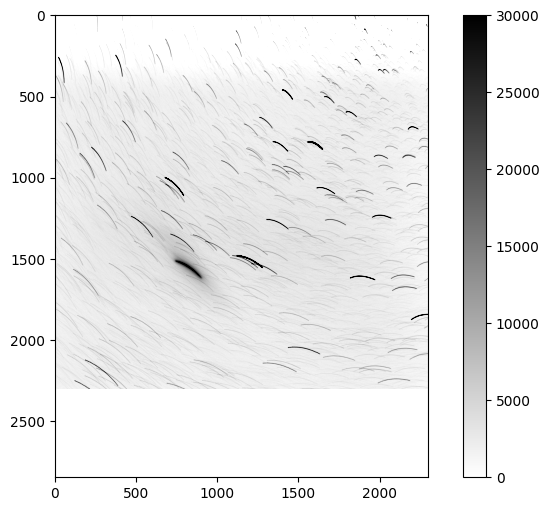

In [18]:
plt.figure(figsize=[9, 6])
plt.imshow(image_stack[aslice], vmin=-10, vmax=30000, cmap='binary')
plt.colorbar()

for file_path in list(positions_tables.keys()):
    positions_t = positions_tables[file_path]
    positions = [(x-xr0,y-yr0) for x,y in zip(positions_t['xcentroid'], positions_t['ycentroid'])]
    apertures = CircularAperture(positions, r=0.1)
    _ = apertures.plot(color='red')
    
#     for position in positions:      does not plot anything...
#         plt.plot(position[0], position[1], color='red')

## Plot only complete sequence stars

Stars with a complete sequence of measured centroids are the ones that make to the last processed image/table in the sequence. Thus, starting from the end image and going backwards (in processing order), we ensure we pick only the complete sequence stars.

In [19]:
# # start from last processed table. 
# file_path_last = list(positions_tables.keys())[-1]
# positions_last = positions_tables[file_path_last]
# refrow_last = positions_last['ref_row']

# file_path_ref = list(positions_tables.keys())[0]  # ref table
# positions_ref = positions_tables[file_path_ref]

# yr0 = 0
# yr1 = image_stack.shape[1]
# xr0 = 0
# xr1 = image_stack.shape[0]
# # yr0 = 1000
# # yr1 = 1200
# # xr0 = 500
# # xr1 = 700

# aslice = np.index_exp[yr0:yr1,xr0:xr1]

# plt.figure(figsize=[9, 6])
# plt.imshow(image_stack[aslice], vmin=-10, vmax=30000, cmap='binary')
# plt.colorbar()

# for i, row in enumerate(refrow_last):
#     ref_row = positions_ref[row]
    
#     x0 = ref_row['xcentroid']
#     y0 = ref_row['ycentroid']
#     x1 = positions_last['xcentroid'][i]
#     y1 = positions_last['ycentroid'][i]

# #     plt.plot( [x0,x1], [y0,y1], 'r', linewidth=1, markersize=1)

#     if x0>xr0 and x0<xr1 and y0>yr0 and y0<yr1 and x1>xr0 and x1<xr1 and y1>yr0 and y1<yr1:
    
#         plt.plot( [x0-xr0,x1-xr0], [y0-yr0,y1-yr0], 'r', linewidth=1, markersize=1)

## Write tables

In [20]:
from astropy.io import fits

keys = list(positions_tables.keys())

for key in keys:
    dirname = os.path.dirname(key)
    fname = os.path.basename(key)
    imagename = fname.split('.')[0]
    tablename = os.path.join(dirname, imagename + '.offsets_table.fits')
    
    table = positions_tables[key]
    
    table.write(tablename, overwrite=True)

    print(tablename)

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00362.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00363.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00364.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00365.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00366.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00367.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00368.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00369.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00370.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00371

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00445.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00446.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00447.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00448.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00449.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00450.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00451.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00452.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00453.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00454

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00532.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00533.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00534.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00535.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00536.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00537.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00538.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00539.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00540.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00541

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00620.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00621.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00622.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00623.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00624.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00625.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00626.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00627.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00628.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00629

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00710.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00711.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00712.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00713.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00714.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00715.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00716.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00717.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00718.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00719

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00800.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00801.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00802.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00803.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00804.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00805.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00806.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00807.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00808.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00809

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00885.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00886.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00887.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00888.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00889.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00890.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00891.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00892.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00893.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00894

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00973.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00974.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00975.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00976.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00977.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00978.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00979.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00980.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00981.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00982

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01063.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01064.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01065.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01066.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01067.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01068.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01069.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01070.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01071.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01072

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01152.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01153.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01154.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01155.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01156.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01157.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01158.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01159.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01160.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01161

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01237.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01238.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01239.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01240.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01241.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01242.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01243.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01244.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01245.offsets_table.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01246